<a href="https://colab.research.google.com/github/gabbycjames/DataScience_Capstone/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Food Desert Investigation -- Modeling

## Imports

In [1]:
import os
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import plotly.graph_objects as go

## Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#%cd drive/My Drive/ColabNotebooks/(DataScience_Capstone/Modeling.i)

In [4]:
df = pd.read_csv('/content/drive/MyDrive/DataScience_Capstone/scaled_data.csv')

In [5]:
df.head()

,FIPS,CACFP_PART_2016,CONVS16,FFR16,FSR16,GROC16,NSLP_PART_2016,PCT_WICINFANTCHILD16,PCT_WICWOMEN16,RECFAC16,...,Asian,Latino,HS_GED,Bachelors,Employed,Unemployed,Midwest,Northeast,South,West
0,-1.939205,-0.45354,-0.096774,-0.118123,-0.176332,-0.197530,-0.398,1.35391,0.898924,-0.130226,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
1,-1.939073,-0.45354,0.799750,0.298354,0.582731,0.090641,-0.398,1.35391,0.898924,0.275224,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
2,-1.938941,-0.45354,-0.220432,-0.196213,-0.239279,-0.186447,-0.398,1.35391,0.898924,-0.292406,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
3,-1.938809,-0.45354,-0.261652,-0.255709,-0.265198,-0.175363,-0.398,1.35391,0.898924,-0.265376,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414
4,-1.938677,-0.45354,-0.137993,-0.196213,-0.246684,-0.175363,-0.398,1.35391,0.898924,-0.184286,...,-0.450608,-0.439182,-0.317678,-0.486712,-0.432052,-0.366769,-0.710826,-0.272468,1.099162,-0.407414


In [6]:
#fig = plt.figure(0)
#plt.grid(True)
#plt.title("Plot of scaled data")
#plt.scatter(X[:,0],X[:,1])
#plt.show()

## K-Means

In [7]:
from sklearn.cluster import KMeans

In [8]:
import sklearn
sklearn.show_versions()


System:
    python: 3.10.12 (main, Sep 11 2024, 15:47:36) [GCC 11.4.0]
executable: /usr/bin/python3
   machine: Linux-6.1.85+-x86_64-with-glibc2.35

Python dependencies:
      sklearn: 1.5.2
          pip: 24.1.2
   setuptools: 71.0.4
        numpy: 1.26.4
        scipy: 1.13.1
       Cython: 3.0.11
       pandas: 2.2.2
   matplotlib: 3.7.1
       joblib: 1.4.2
threadpoolctl: 3.5.0

Built with OpenMP: True

threadpoolctl info:
       user_api: blas
   internal_api: openblas
    num_threads: 2
         prefix: libopenblas
       filepath: /usr/local/lib/python3.10/dist-packages/numpy.libs/libopenblas64_p-r0-0cf96a72.3.23.dev.so
        version: 0.3.23.dev
threading_layer: pthreads
   architecture: Haswell

       user_api: blas
   internal_api: openblas
    num_threads: 2
         prefix: libopenblas
       filepath: /usr/local/lib/python3.10/dist-packages/scipy.libs/libopenblasp-r0-01191904.3.27.so
        version: 0.3.27
threading_layer: pthreads
   architecture: Haswell

       user

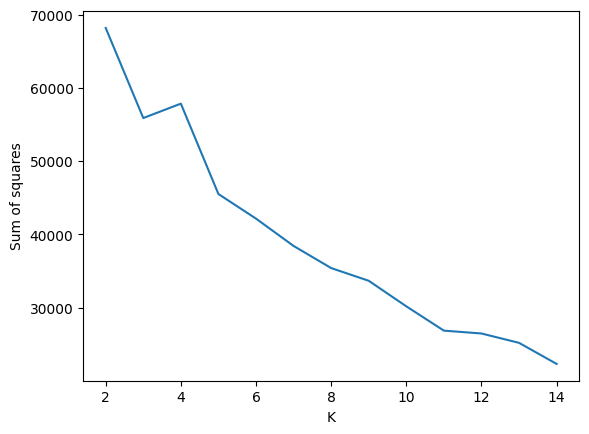

In [9]:
ss = []
possible_k = {}
Krange = list(range(2,15))
X = df.to_numpy()

for i in Krange:
    model = KMeans(n_clusters=i)
    current_cluster = model.fit_predict(X)
    centers = model.cluster_centers_
    ss.append(np.sum((X - centers[current_cluster])**2))
    possible_k[str(i)] = current_cluster

plt.plot(Krange,ss)
plt.xlabel("K")
plt.ylabel("Sum of squares")
plt.show()


In [11]:
#ss = []
#for i in range(1,11):
#   KM = KMeans(n_clusters=i, max_iter=500)
#    KM.fit(df)
#    ss.append(KM.inertia_)



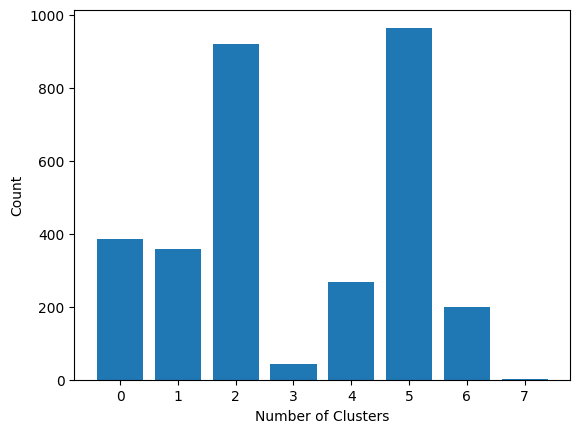

In [15]:
K = 8
best_K = possible_k[str(K)]
count = np.bincount(best_K)
_ = plt.bar(range(K), height=count, align='center')
_ = plt.xlabel('Number of Clusters')
_ = plt.ylabel('Count')
_ = plt.show()